# ECE 228 Unet (Kaggle nucleus dataset)

# Python imports

In [1]:
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
%matplotlib inline  

import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms, utils
from skimage import io, transform
from skimage.color import rgb2gray

from models import * 
from train import *


# Load nucleus data

Training images shape =  (670, 3, 128, 128)
Training labels shape =  (670, 1, 128, 128)


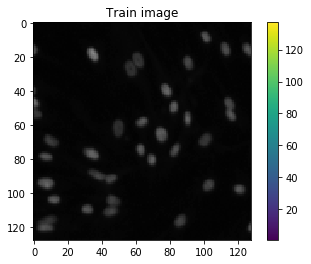

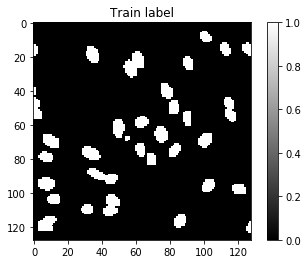

In [2]:
X_train = np.load('datasets/nucleus_train_images.npy')
X_train = (X_train/127)-1
Y_train = np.load('datasets/nucleus_train_labels.npy').astype(np.uint8)

print("Training images shape = ",X_train.shape)
print("Training labels shape = ",Y_train.shape)
original_imgs = (127*(np.moveaxis(X_train, 1, -1)+1)).astype(np.uint8)

plt.imshow(original_imgs[0])
plt.title("Train image")
plt.colorbar()
plt.show()

plt.imshow(np.squeeze(Y_train[0,:,:,:]), cmap="gray")
plt.title("Train label")
plt.colorbar()
plt.show()



# Run Training

GPU is enabled 
80/20 training/validation split
total_train_size =  670
val_size =  134
epoch: 0, train loss: 0.14637857322310055


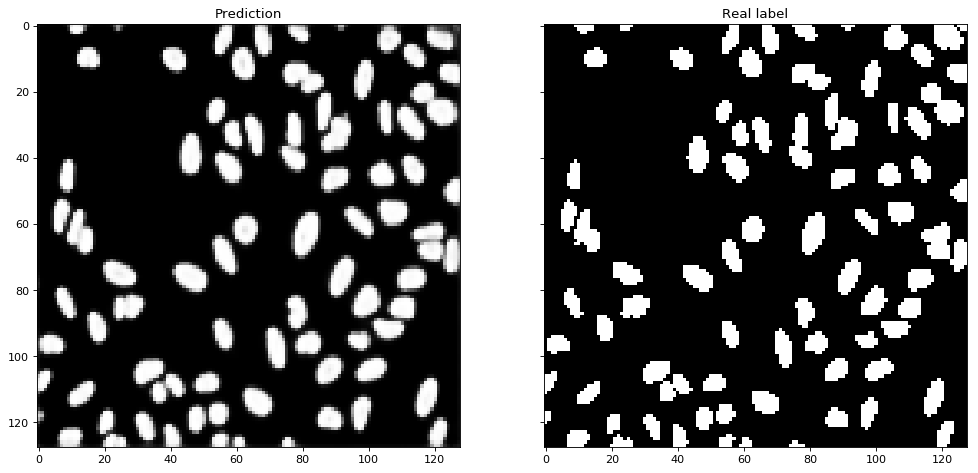

Network evaluation at epoch: 0 

train_avg_loss = 0.0939, train_avg_f1_score = 0.7608 
train_avg_precision = 0.6407, train_avg_recall = 0.9808 

val_avg_loss = 0.1085, val_avg_f1_score = 0.7679 
val_avg_precision = 0.6456, val_avg_recall = 0.9844 


epoch: 1, train loss: 0.09077780541213257


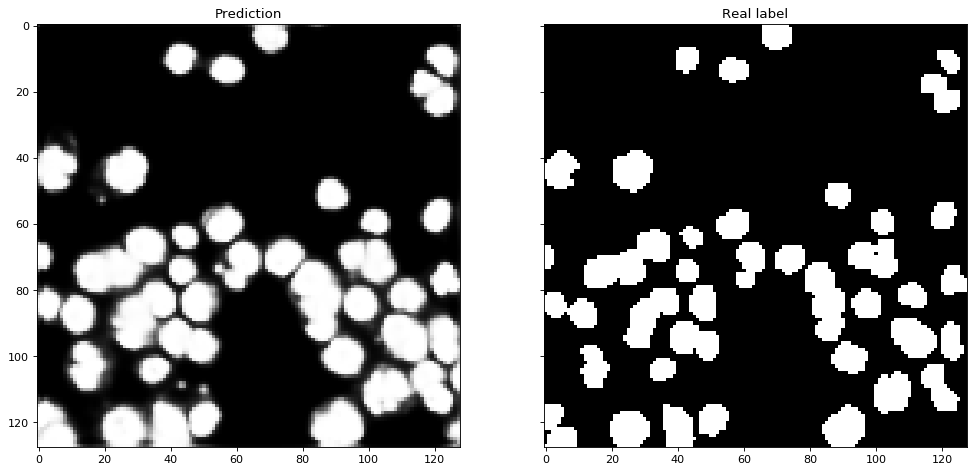

epoch: 2, train loss: 0.08322894595582525


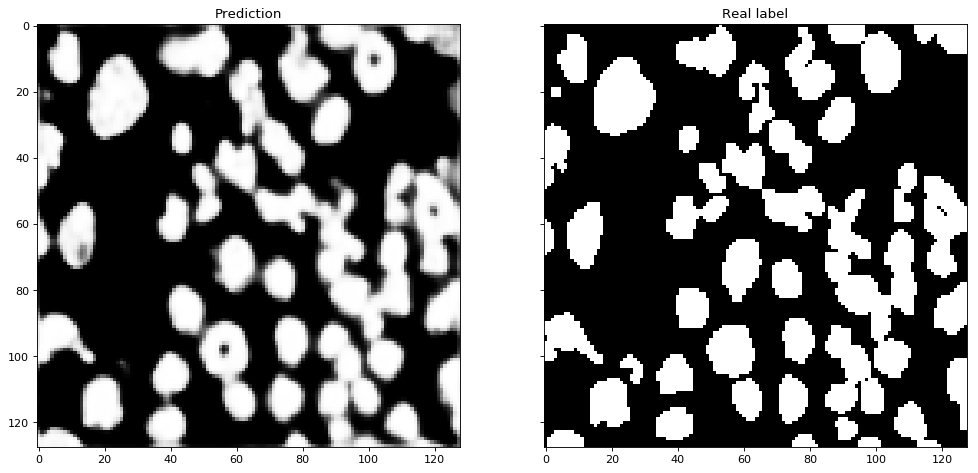

epoch: 3, train loss: 0.08411620387984718


KeyboardInterrupt: 

In [3]:
# Prep GPU
GPU = torch.cuda.is_available()
print("GPU is {}enabled ".format(['not ', ''][GPU]))

batch_size = 1
n_epochs = 100


#unet(n_channels, n_classes, n_filters_start=64 )
un = unet(3,1)
if GPU: 
    un = un.cuda()

optimizer = torch.optim.Adam(un.parameters(), lr=0.01)
criterion = nn.BCELoss()




# split into training and validation set 
total_train_size = X_train.shape[0]
p = np.random.permutation(total_train_size)
X_train = X_train[p]
Y_train = Y_train[p]

val_size = int(0.2*total_train_size)

X_val = X_train[:val_size]
Y_val = Y_train[:val_size]

X_train = X_train[val_size:]
Y_train = Y_train[val_size:]

print("80/20 training/validation split")
print("total_train_size = ",total_train_size)
print("val_size = ", val_size)



# run training 
training(GPU, un,X_train, Y_train, X_val, Y_val, optimizer, criterion, n_epochs, batch_size)


In [ ]:
whos


# todo 

0. model.train() vs model.eval()
1. tune prediction threshold parameter 
2. disconnecting objects 
3. more datasets 
4. inception modules 